In [5]:
import geopandas
import requests
import datetime
import calendar
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import opendatasets as od

from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
from google.cloud import bigquery

In [6]:
def url_generator(lat, lon, date):
    url = f'https://api.sunrisesunset.io/json?lat={str(lat)}&lng={str(lon)}&timezone=UTC&date={date}'
    return url

In [7]:
def get_tr_city_cp(city):
    humdata_url = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/b1d18b54-7175-4d32-85e9-a4710509dbfb/download/turkey_centeralpoints_1_2.zip'
    turkey_centeralpoints = geopandas.read_file(humdata_url)[['adm1_en', 'latitude', 'longitude']]
    turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})
    
    [lat, long] = turkey_centeralpoints[turkey_centeralpoints['city'] == city][['latitude', 'longitude']].iloc[0]

    return lat, long

In [8]:
# converts time to minutes 
def total_mins(time):
    s = datetime.timedelta(hours = time.hour,
                            minutes = time.minute)
    mins = s.total_seconds() / 60
    return mins

In [9]:
def get_sunset_sunrise(city):
    df = pd.DataFrame(columns = ['date', 'sunrise', 'sunset', 'solar_noon', 'sunrise(minutes)', 'sunset(minutes)', 'solar_noon(minutes)'])

    city_lat, city_long = get_tr_city_cp(city)
    start_date = datetime.date(2022, 1, 1)
    end_date = datetime.date(2022, 12, 31)

    delta = datetime.timedelta(days=1)
    while (start_date <= end_date):
        date_url = url_generator(city_lat, city_long, f'{start_date.year}-{start_date.month}-{start_date.day}')
        req = requests.get(date_url).json()['results']

        sunrise = req['sunrise']
        sunset = req['sunset']
        solarnoon = req['solar_noon']

        date = datetime.datetime(start_date.year, start_date.month, start_date.day)
        sunrise = datetime.datetime.strptime(sunrise[:-3], '%H:%M:%S') 
        sunset = datetime.datetime.strptime(sunset[:-3], '%H:%M:%S')
        solarnoon = datetime.datetime.strptime(solarnoon[:-3], '%H:%M:%S')

        sunrise += datetime.timedelta(hours=3)
        sunset += datetime.timedelta(hours=12+3)
        solarnoon += datetime.timedelta(hours=3)

        sunrise_mins = total_mins(sunrise)
        sunset_mins = total_mins(sunset)
        solarnoon_mins = total_mins(solarnoon)

        new_row = pd.DataFrame([[date, sunrise, sunset, solarnoon, sunrise_mins, sunset_mins, solarnoon_mins]],
                            columns=['date', 'sunrise', 'sunset', 'solar_noon', 'sunrise(minutes)', 'sunset(minutes)', 'solar_noon(minutes)'])

        df = pd.concat([df, new_row])

        start_date += delta

    return df

In [10]:
def plot_sunrise_sunset(city, ax):
    df = get_sunset_sunrise(city)

    ax.plot(np.arange(0, 365), df['sunrise(minutes)'], label='sunrise')
    ax.plot(np.arange(0, 365), df['sunset(minutes)'], label='sunset')
    ax.plot(np.arange(0, 365), df['solar_noon(minutes)'], label='solar_noon')
    ax.axhline(y=8*60, color='red', linewidth=3, label='08:00')

    ax.grid()

    ax.set_ylabel('Time')
    ax.set_title(city)
    ax.legend()

    ax.set_xticks(np.arange(0, 365, step=31))
    ax.set_xticklabels(calendar.month_name[1:], rotation=30)

    ax.set_yticks(np.arange(0, 24*60, step=60*2))
    ax.set_yticklabels(np.arange(0, 24, step=2))

In [11]:
def get_us_accidents_data_by_year(year):
    s = f'bigquery-public-data.nhtsa_traffic_fatalities.accident_{year}'
    query = f'''
        SELECT COUNT(consecutive_number) AS num_accidents,
               EXTRACT(DAY FROM timestamp_of_crash) AS day,
               EXTRACT(MONTH FROM timestamp_of_crash) AS month,
               EXTRACT(YEAR FROM timestamp_of_crash) AS year,   
               EXTRACT(DATE FROM timestamp_of_crash) AS date,
               EXTRACT(DAYOFWEEK FROM timestamp_of_crash) AS weekday
        FROM `{s}`
        GROUP BY date, year, month, day, weekday
        ORDER BY date
        '''

    client = bigquery.Client()

    query_job = client.query(query)
    accidents_by_date = query_job.to_dataframe()

    return accidents_by_date

In [12]:
def get_data_by_date(df, day = 1, month = 1, date = ''):
    if date != '':
        day, month, year = [int(x) for x in date.split('-')]

    data_by_date = (df[(df['day'] == day) &
                       (df['month'] == month)])

    return data_by_date

In [13]:
def plot_accidents_by_date(ax, year):
    if year == 2015:
        accidents = get_us_accidents_data_by_year(2015)
        # 8 Mar 2015 - Daylight Saving Time Started
        dst_started = get_data_by_date(accidents, day=8+1, month=3)
        # 1 Nov 2015 - Daylight Saving Time Ended
        dst_ended = get_data_by_date(accidents, day=1+1, month=11)
    elif year == 2016:
        accidents = get_us_accidents_data_by_year(2016)
        # 13 Mar 2016 - Daylight Saving Time Started
        dst_started = get_data_by_date(accidents, day=13+1, month=3)
        # 6 Nov 2016 - Daylight Saving Time Ended
        dst_ended = get_data_by_date(accidents, day=6+1, month=11)

    monday_mean = accidents[accidents['weekday'] == 2]['num_accidents'].mean()
        
    ax.plot(accidents.index, accidents['num_accidents'])
    ax.scatter(dst_started.index,
               dst_started['num_accidents'],
               color='green',
               s = 150,
               label='dst started')
    ax.scatter(dst_ended.index,
               dst_ended['num_accidents'],
               color='red',
               s = 150,
               label='dst ended')
    ax.axhline(y=monday_mean,
               color='black',
               label = 'total mean')

    ax.set_ylabel('Number of accidents')
    ax.set_title(f'US Traffic Accidents ({year})',
                 fontweight = 'bold',
                 fontsize = 20)
    ax.set_xticks(np.arange(0, 365, step=31))
    ax.set_xticklabels(calendar.month_name[1:], rotation=30)
    ax.legend()

In [45]:
def plot_weekday_means(ax, year):
    weekdays = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    accidents = get_us_accidents_data_by_year(year)
    means = accidents.groupby('weekday',  as_index=False)['num_accidents'].mean()

    ax.bar(weekdays, means['num_accidents'])
    ax.set_title(f'Number of accidents by weekday ({year})')


In [75]:
def monday_accidents_quantiles(year):
    accidents = get_us_accidents_data_by_year(year)
    monday_accidents = accidents[accidents["weekday"] == 2]

    quantiles_df = monday_accidents[['num_accidents']].quantile([.25, .5, .75, .90])

    return quantiles_df

### In 2016 Turkey decided to remain permanently in the summertime zone. Which time zone is better for Turkey (summer or winter)?

### Turkey Population Density Map

In [14]:
tuik_url = 'https://data.tuik.gov.tr/Bulten/DownloadIstatistikselTablo?p=OW4kk4KIauRVHwQK9tma/jlD055DCNYc4XuRAZwpy550wSt7B4cANX305nVsp//V'
tuik_pop = pd.read_excel(tuik_url)

In [15]:
turkey_2021_pop = tuik_pop.iloc[4:85, [0, 22]].reset_index(drop = True)
turkey_2021_pop.columns = ['city', 'population']

In [16]:
turkey_2021_pop['city'] = turkey_2021_pop['city'].apply(lambda city : city.upper())
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ç', 'C')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ğ', 'G')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('İ', 'I')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ö', 'O')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ş', 'S')
turkey_2021_pop['city'] = turkey_2021_pop['city'].str.replace('Ü', 'U')

In [17]:
humdata_url1 = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/6cc83f12-885f-475b-98f7-9bad99d682b9/download/turkey_administrativelevels0_1_2.zip'
turkey_adm = geopandas.read_file(humdata_url1)[['adm1_en', 'geometry']]
turkey_adm = turkey_adm.rename(columns={'adm1_en': 'city'})

In [18]:
turkey_pop_geo = pd.merge(turkey_adm, turkey_2021_pop)

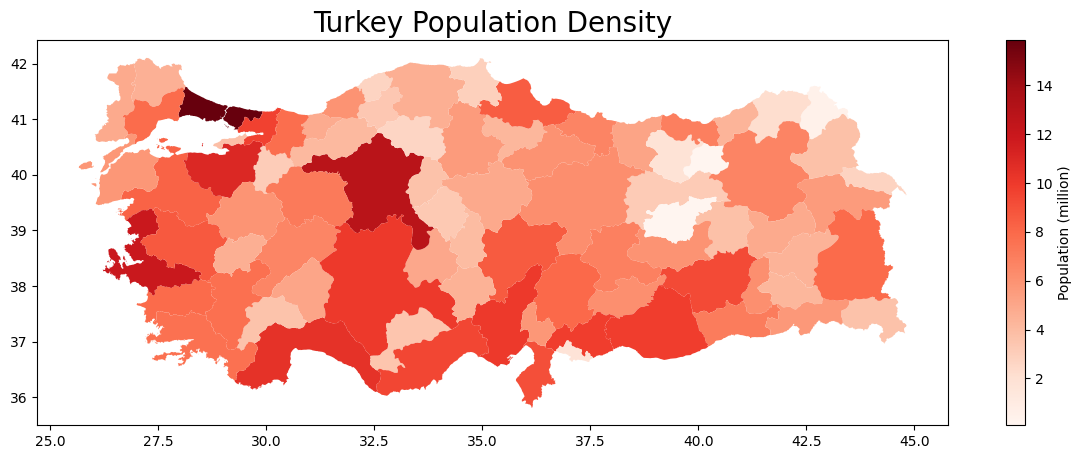

In [19]:
turkey_pop_geo['population(log())'] = np.log(turkey_pop_geo['population'])

fig, ax = plt.subplots(figsize=(15,5))
ax.set_title("Turkey Population Density", size=20)
turkey_pop_geo.plot(column="population(log())", cmap="Reds", ax=ax)
n = colors.Normalize(turkey_pop_geo.population.min()/1000000, turkey_pop_geo.population.max()/1000000)
cbar = plt.cm.ScalarMappable(norm=n, cmap="Reds")
ax_cbar = fig.colorbar(cbar, ax=ax)
ax_cbar.set_label("Population (million)")

### Turkey's Population Density Point

In [20]:
humdata_url2 = 'https://data.humdata.org/dataset/ac768a5c-db29-4872-9792-bd3179e29c45/resource/b1d18b54-7175-4d32-85e9-a4710509dbfb/download/turkey_centeralpoints_1_2.zip'
turkey_centeralpoints = geopandas.read_file(humdata_url2)[['adm1_en', 'latitude', 'longitude']]
turkey_centeralpoints = turkey_centeralpoints.rename(columns={'adm1_en': 'city'})

In [21]:
turkey_pop_lot_long = pd.merge(turkey_centeralpoints, turkey_2021_pop)

In [22]:
turkey_total_pop = turkey_2021_pop['population'].sum()

In [23]:
pop_cp_lat = np.sum(turkey_pop_lot_long['latitude']*turkey_pop_lot_long['population'])/turkey_total_pop
pop_cp_long = np.sum(turkey_pop_lot_long['longitude']*turkey_pop_lot_long['population'])/turkey_total_pop

df = pd.DataFrame({'latitude': [pop_cp_lat],'longitude': [pop_cp_long]})

pop_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

In [24]:
geo_cp_lat = (min(turkey_pop_lot_long['latitude']) + max(turkey_pop_lot_long['latitude'])) / 2
geo_cp_long = (min(turkey_pop_lot_long['longitude']) + max(turkey_pop_lot_long['longitude'])) / 2

df = pd.DataFrame({'latitude': [geo_cp_lat],'longitude': [geo_cp_long]})

geo_cp = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.longitude, df.latitude))

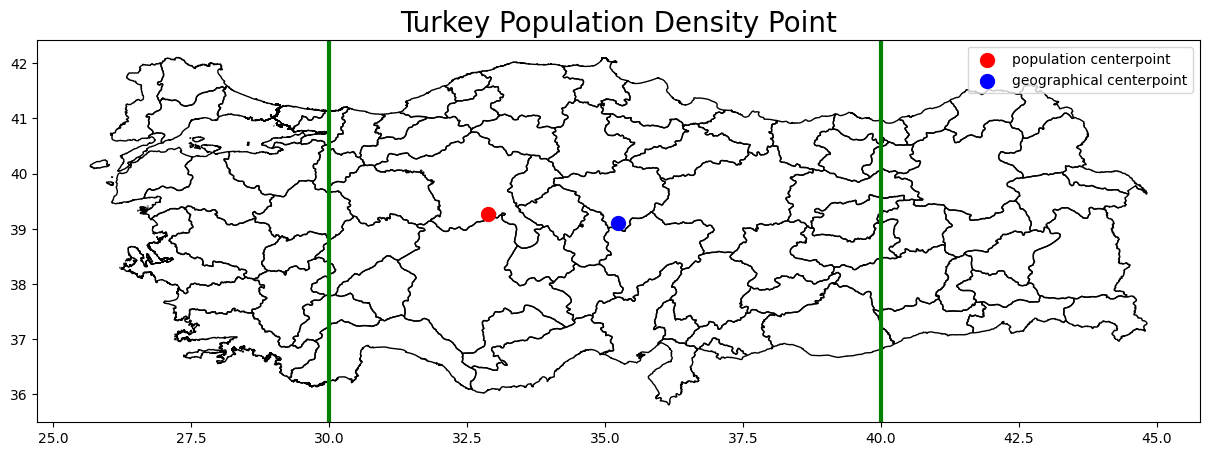

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))

turkey_adm.plot(ax = ax,edgecolor="k", facecolor="none")
pop_cp.plot(ax = ax, color='red', markersize = 100, label='population centerpoint')
geo_cp.plot(ax = ax, color='blue', markersize = 100, label='geographical centerpoint')
ax.axvline(x=30, color='green', linewidth=3)
ax.axvline(x=40, color='green', linewidth=3)

ax.set_title("Turkey Population Density Point", size=20)
ax.legend()

plt.show()

### Which cities are worst affected by the permanent summertime in Turkey?

longitude a baktigimizda 40 meridyenine en uzak olanlar en kotu etkileniyor diyebiliriz

In [26]:
turkey_centeralpoints['cpDistanceMeridian40'] = abs(turkey_centeralpoints['longitude']-40)

Top 5 most affected cities:

In [27]:
turkey_centeralpoints.sort_values(by='cpDistanceMeridian40', ascending=False)[:5]

,city,latitude,longitude,cpDistanceMeridian40
21,CANAKKALE,40.146498,26.406294,13.593706
27,EDIRNE,41.676425,26.552412,13.447588
40,IZMIR,38.434144,27.171866,12.828134
49,KIRKLARELI,41.735924,27.218857,12.781143
55,MANISA,38.622270,27.433657,12.566343


In [28]:
affected_df = pd.merge(turkey_adm, turkey_centeralpoints)

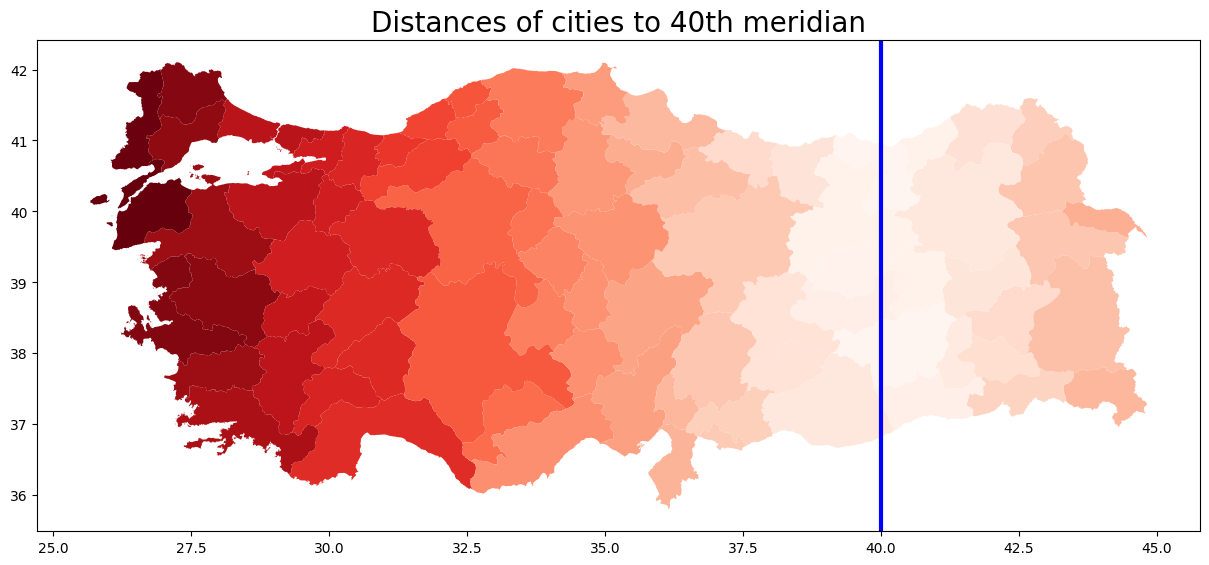

In [29]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.set_title("Distances of cities to 40th meridian", size=20)
affected_df.plot(column='cpDistanceMeridian40', cmap="Reds", ax=ax)
ax.axvline(x=40, color='blue', linewidth=3)

### Preliminary results of the public consultation on time change in Europe (2018)

In [30]:
results = pd.DataFrame([['Austria', 0.77],
                        ['Belgium', 0.84],
                        ['Bulgaria', 0.84],
                        ['Croatia', 0.90],
                        ['Cyprus', 0.47],
                        ['Czechia', 0.83],
                        ['Denmark', 0.81],
                        ['Estonia', 0.85],
                        ['Finland', 0.95],
                        ['France', 0.84],
                        ['Germany', 0.84],
                        ['Greece', 0.44],
                        ['Hungary', 0.90],
                        ['Ireland', 0.88],
                        ['Italy', 0.66],
                        ['Latvia', 0.85],
                        ['Lithuania', 0.91],
                        ['Luxembourg', 0.79],
                        ['Malta', 0.54],
                        ['Netherlands', 0.79],
                        ['Poland', 0.95],
                        ['Portugal', 0.85],
                        ['Romania', 0.78],
                        ['Slovakia', 0.80],
                        ['Slovenia', 0.87],
                        ['Spain', 0.93],
                        ['Sweden', 0.88],
                        ['United Kingdom', 0.82]],
                        columns = ['country', 'abolish'])
results['keep'] = (1-results['abolish'])*100
results['abolish'] = results['abolish']*100



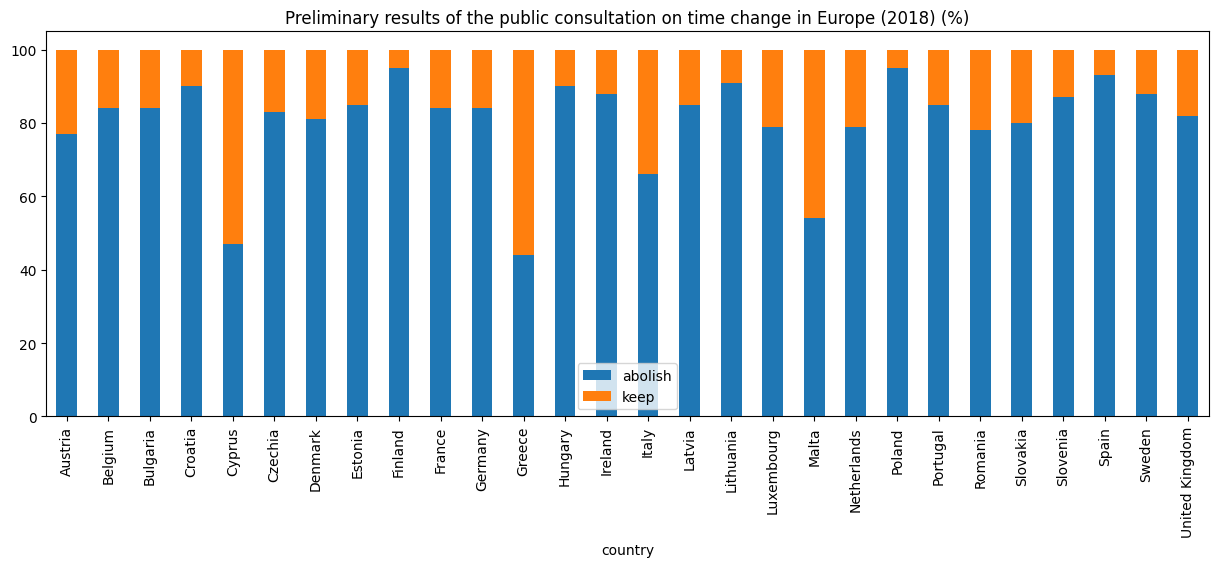

In [31]:
results.plot.bar(x = 'country', stacked='true', title='Preliminary results of the public consultation on time change in Europe (2018) (%)', figsize=(15, 5))
plt.show()

## Sunrise and Sunset Times for Cities in Turkey

* __Çanakkale__ -> western edge of Turkey
* __Yozgat__ -> geographical centerpoint of Turkey
* __Iğdır__ -> eastern edge of Turkey
* __Istanbul__ -> the most crowded city in Turkey

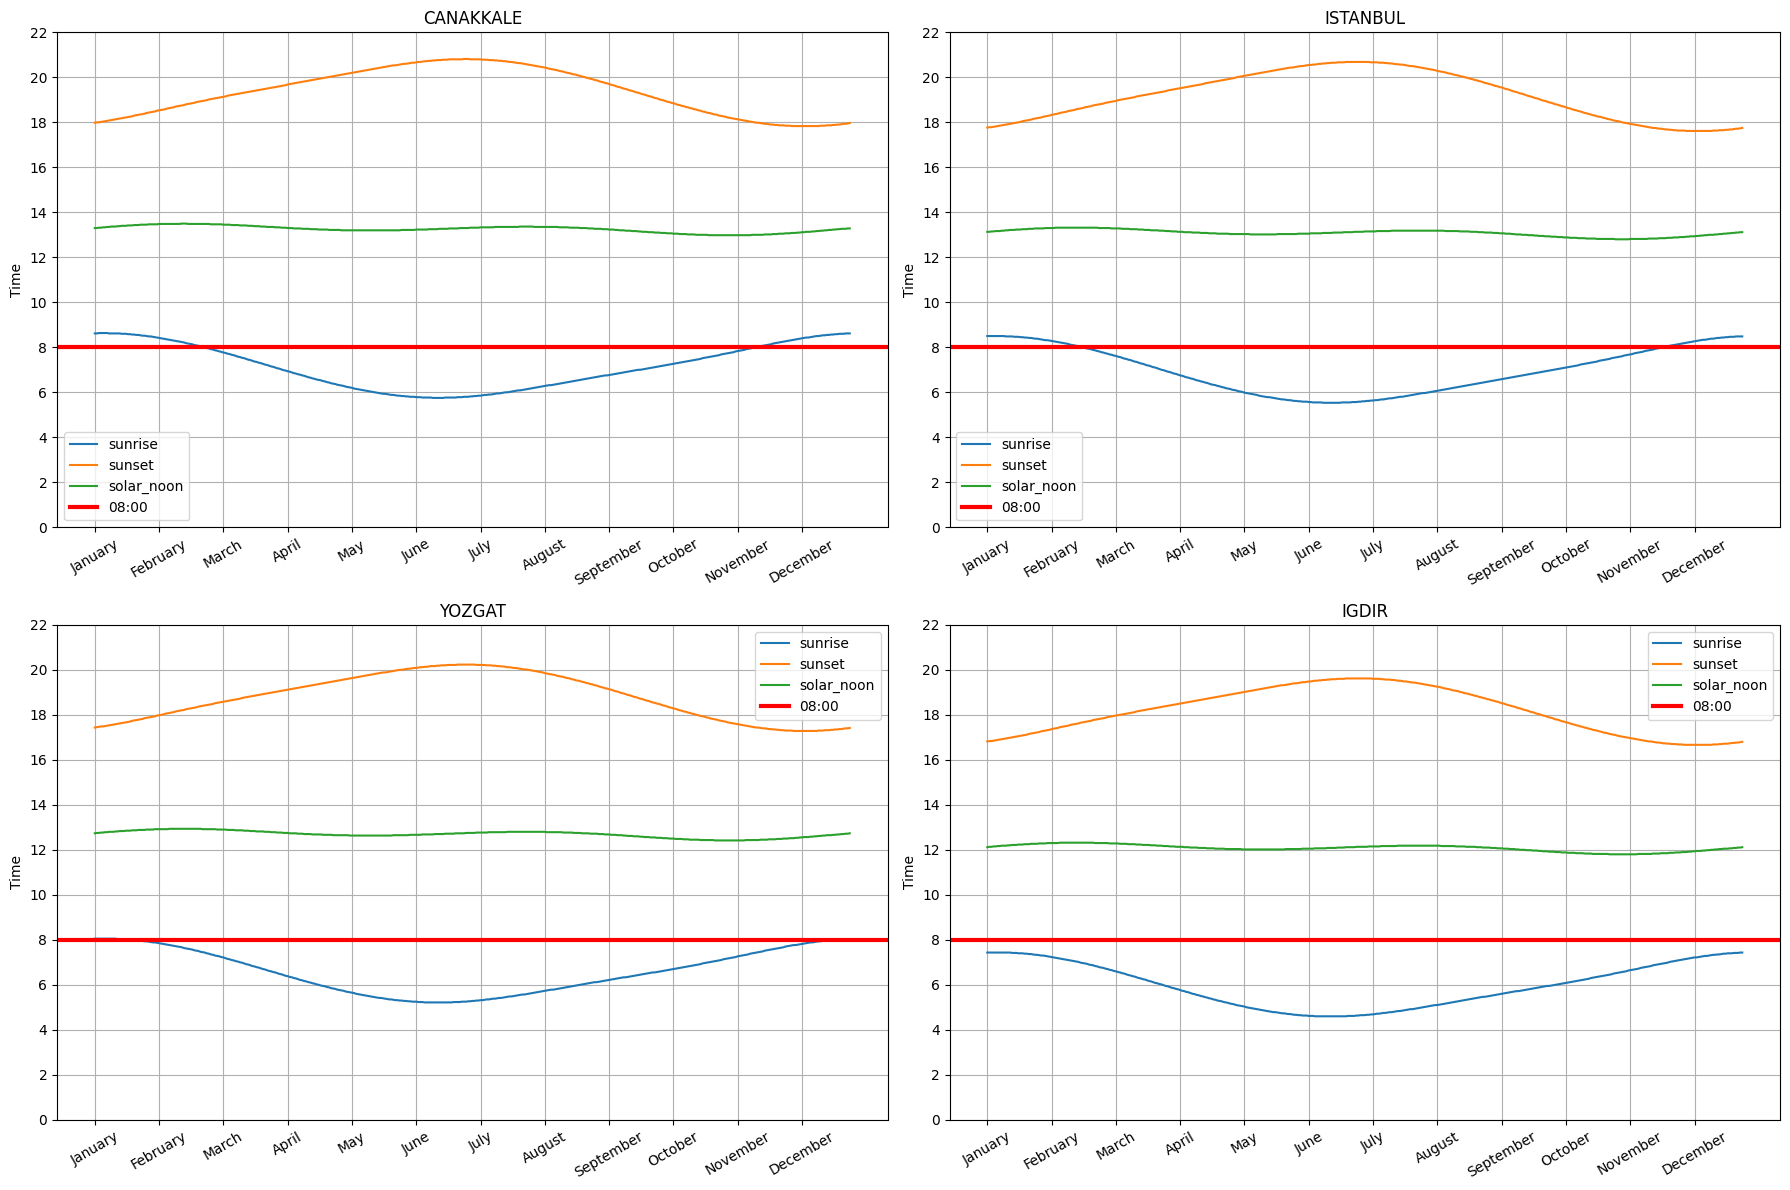

In [32]:
cities = ['CANAKKALE', 'ISTANBUL', 'YOZGAT', 'IGDIR']
x, y = 0, 0

fig, axs = plt.subplots(2, 2, figsize=(18,12))

for city in cities:
    if(y==2):
        y=0
        x+=1
    plot_sunrise_sunset(city, axs[x, y])
    y += 1

fig.tight_layout()

plt.show()

## US Traffic Accidents and Daylight Savings Time

* 2015: 
    * 8 Mar 2015 (Sunday) - Daylight Saving Time Started
    * 1 Nov 2015 (Sunday) - Daylight Saving Time Ended
* 2016:
    * 13 Mar 2016 (Sunday) - Daylight Saving Time Started
    * 6 Nov 2016 (Sunday) - Daylight Saving Time Ended

We will analyze the following Mondays.

In [33]:
# You can get google application credenitals from https://console.cloud.google.com
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/Users/sahin/.google/mat388e-8b89c195b495.json'

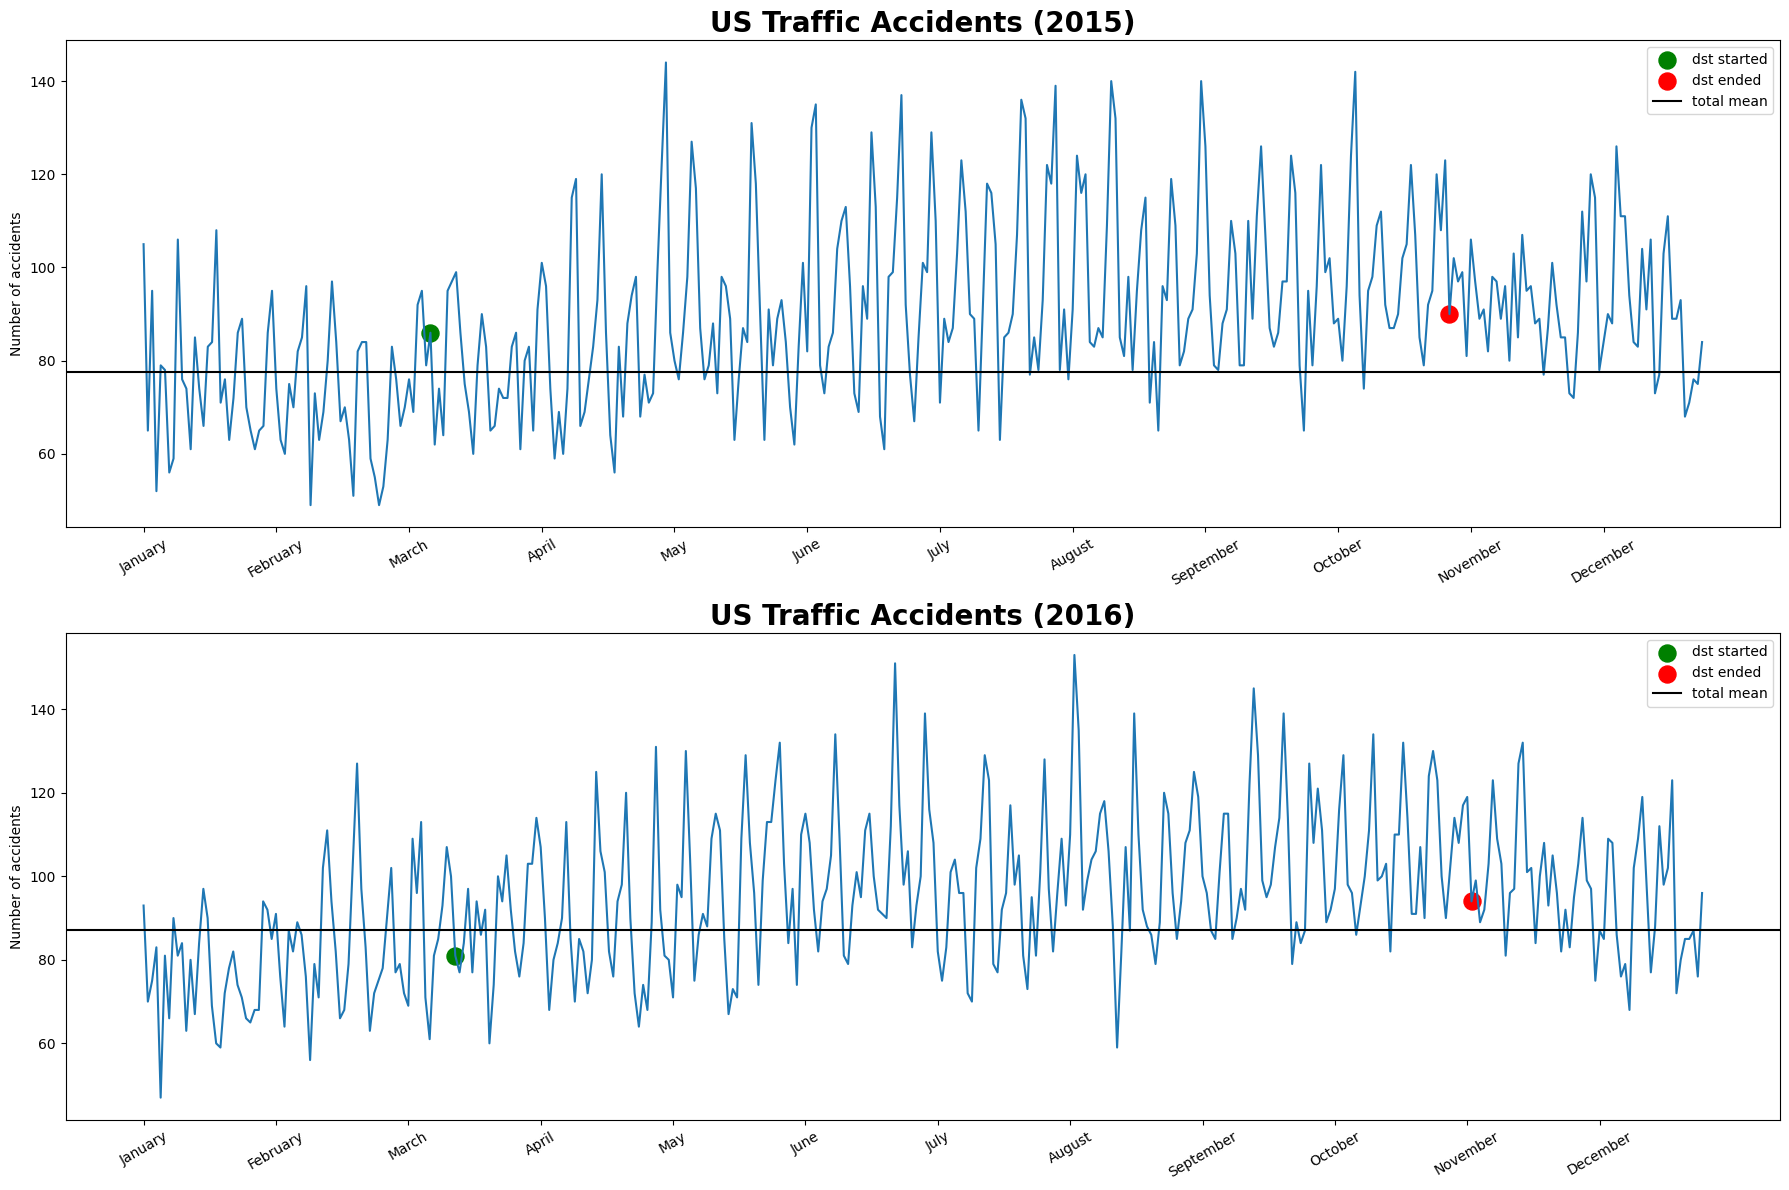

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(18,12))

plot_accidents_by_date(axs[0], year=2015)
plot_accidents_by_date(axs[1], year=2016)

fig.tight_layout()

plt.show()

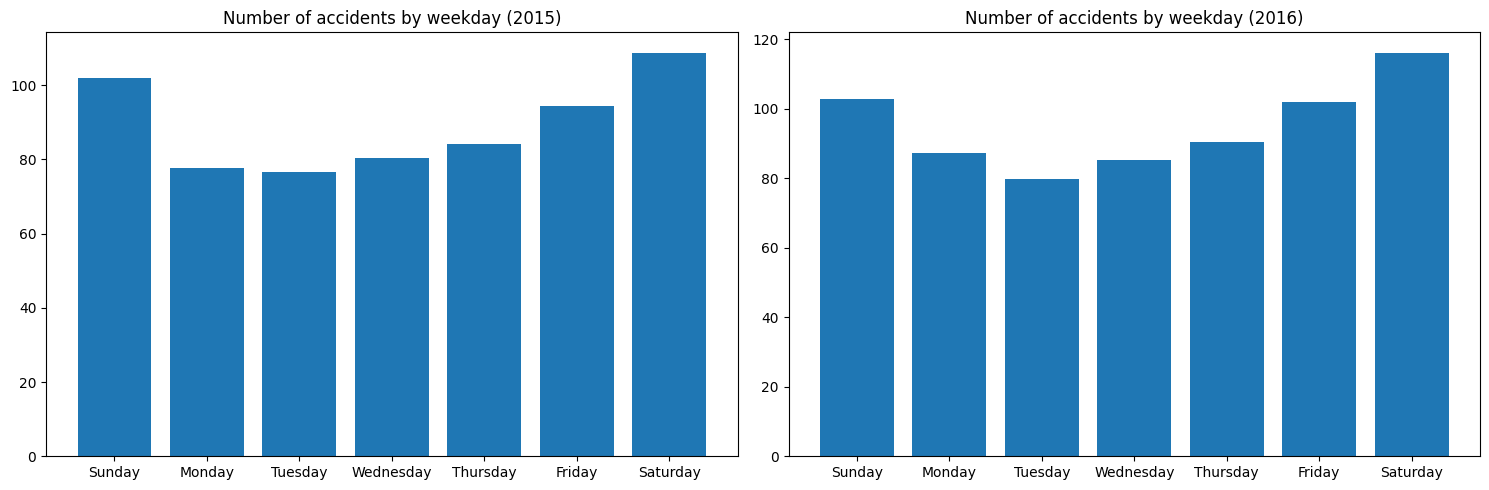

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

plot_weekday_means(axs[0], year=2015)
plot_weekday_means(axs[1], year=2016)

fig.tight_layout()

plt.show()

We will use [Pandas dataframe.quantile()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.quantile.html) function to test whether daylight saving time is causing an increase in traffic accidents in the USA. This function returns values at the given quantile over requested axis.

In [78]:
accidents_2015 = get_us_accidents_data_by_year(2015)

dst_started_2015 = get_data_by_date(accidents_2015, day=8+1, month=3)
dst_ended_2015 = get_data_by_date(accidents_2015, day=1+1, month=11)

print(f'Number of accidents when dst started for 2015: {dst_started_2015["num_accidents"].iloc[0]}')
print(f'Number of accidents when dst ended for 2015: {dst_ended_2015["num_accidents"].iloc[0]}')

monday_accidents_quantiles(2015)

Number of accidents when dst started for 2015: 86
Number of accidents when dst ended for 2015: 90


,num_accidents
0.25,68.0
0.50,78.5
0.75,87.0
0.90,90.0


In [80]:
accidents_2016 = get_us_accidents_data_by_year(2016)

dst_started_2016 = get_data_by_date(accidents_2016, day=13+1, month=11)
dst_ended_2016 = get_data_by_date(accidents_2016, day=6+1, month=11)

print(f'Number of accidents when dst started for 2016: {dst_started_2016["num_accidents"].iloc[0]}')
print(f'Number of accidents when dst ended for 2016: {dst_ended_2016["num_accidents"].iloc[0]}')

monday_accidents_quantiles(2016)

Number of accidents when dst started for 2016: 103
Number of accidents when dst ended for 2016: 94


,num_accidents
0.25,79.75
0.50,86.5
0.75,96.25
0.90,100.9
